# Multiscale Object Detection

In :numref:`sec_anchor`, we generated multiple anchor boxes centered on each pixel of the input image.  These anchor boxes are used to sample different regions of the input image. However, if anchor boxes are generated centered on each pixel of the image, soon there will be too many anchor boxes for us to compute. For example, we assume that the input image has a height and a width of 561 and 728 pixels respectively. If five different shapes of anchor boxes are generated centered on each pixel, over two million anchor boxes ($561 \times 728 \times 5$) need to be predicted and labeled on the image.

It is not difficult to reduce the number of anchor boxes.  An easy way is to apply uniform sampling on a small portion of pixels from the input image and generate anchor boxes centered on the sampled pixels. In addition, we can generate anchor boxes of varied numbers and sizes on multiple scales. Notice that smaller objects are more likely to be positioned on the image than larger ones.  Here, we will use a simple example: Objects with shapes of $1 \times 1$, $1 \times 2$, and $2 \times 2$ may have 4, 2, and 1 possible position(s) on an image with the shape $2 \times 2$. Therefore, when using smaller anchor boxes to detect smaller objects, we can sample more regions; when using larger anchor boxes to detect larger objects, we can sample fewer regions.

To demonstrate how to generate anchor boxes on multiple scales, let us read an image first.  It has a height and width of $561 \times 728$ pixels.


In [1]:
%use @file[../djl.json]
@file:DependsOn("../D2J-1.0-SNAPSHOT.jar")
//import jp.live.ugai.d2j.attention.Chap10Utils
import jp.live.ugai.d2j.util.ImageUtils

In [2]:
val img = ImageFactory.getInstance()
                .fromUrl("https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/catdog.jpg");
val HEIGHT = img.getHeight();
val WIDTH = img.getWidth();

"${HEIGHT}, ${WIDTH}"

561, 728

In :numref:`sec_conv_layer`, the 2D array output of the convolutional neural network (CNN) is called
a feature map.  We can determine the midpoints of anchor boxes uniformly sampled
on any image by defining the shape of the feature map.

The function `displayAnchors()` is defined below.  We are going to generate anchor boxes `anchors` centered on each unit (pixel) on the feature map `fmap`.  Since the coordinates of axes $x$ and $y$ in anchor boxes `anchors` have been divided by the width and height of the feature map `fmap`, values between 0 and 1 can be used to represent relative positions of anchor boxes in the feature map.  Since the midpoints of anchor boxes `anchors` overlap with all the units on feature map `fmap`, the relative spatial positions of the midpoints of the `anchors` on any image must have a uniform distribution.  Specifically, when the width and height of the feature map are set to `fmapWidth` and `fmapHeight` respectively, the function will conduct uniform sampling for `fmapHeight` rows and `fmapWidth` columns of pixels and use them as midpoints to generate anchor boxes with size `size` (we assume that the length of list `size` is 1) and different aspect ratios (`ratios`).


In [3]:
fun displayAnchors(img: Image , fmapWidth: Int, fmapHeight: Int,sizes: List<Float> ) {
    val manager = NDManager.newBaseManager();
    val fmap = manager.zeros(Shape(1, 10, fmapWidth.toLong(), fmapHeight.toLong()));

    val ratios = listOf(1f, 2f, 0.5f);

    val mbp = MultiBoxPrior.builder().setSizes(sizes).setRatios(ratios).build();
    val anchors = mbp.generateAnchorBoxes(fmap);

    ImageUtils.drawBBoxes(img, anchors.get(0), null);
}

We will first focus on the detection of small objects. In order to make it easier to distinguish upon display, the anchor boxes with different midpoints here do not overlap. We assume that the size of the anchor boxes is 0.15 and the height and width of the feature map are 4. We can see that the midpoints of anchor boxes from the 4 rows and 4 columns on the image are uniformly distributed.



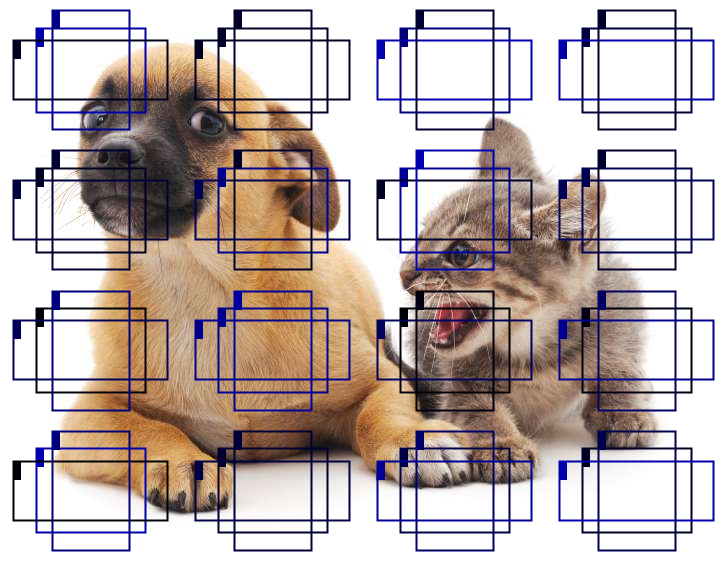

In [7]:
val img2 = img.duplicate();
displayAnchors(img2, 4, 4, listOf(0.15f));

img2.getWrappedImage()

We are going to reduce the height and width of the feature map by half and use a larger anchor box to detect larger objects. When the size is set to 0.4, overlaps will occur between regions of some anchor boxes.



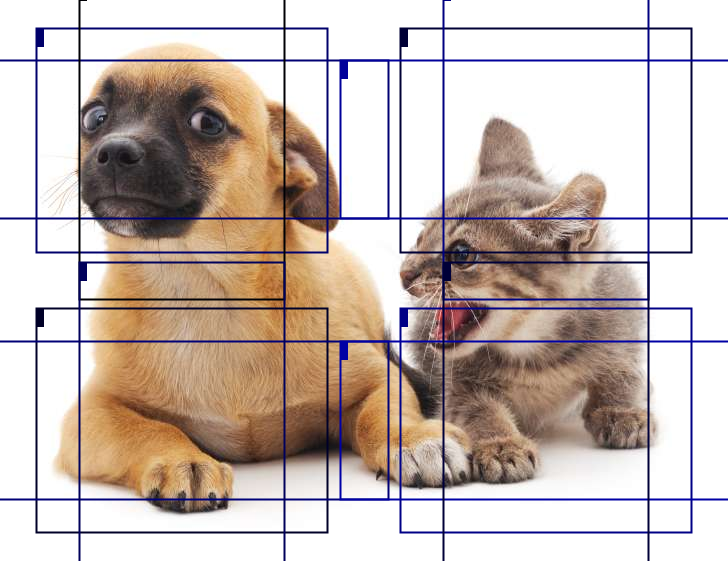

In [8]:
val img3 = img.duplicate();
displayAnchors(img3, 2, 2, listOf(0.4f));

img3.getWrappedImage()

Finally, we are going to reduce the height and width of the feature map by half and increase the anchor box size to 0.8. Now the midpoint of the anchor box is the center of the image.



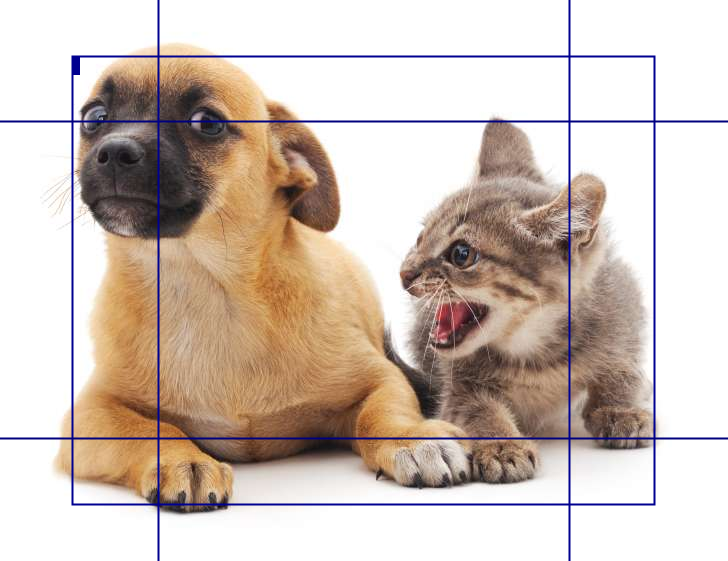

In [9]:
val img4 = img.duplicate();
displayAnchors(img4, 1, 1, listOf(0.8f));

img4.getWrappedImage()

Since we have generated anchor boxes of different sizes on multiple scales, we will use them to detect objects of various sizes at different scales. Now we are going to introduce a method based on convolutional neural networks (CNNs).

At a certain scale, suppose we generate $h \times w$ sets of anchor boxes with different midpoints based on $c_i$ feature maps with the shape $h \times w$ and the number of anchor boxes in each set is $a$. For example, for the first scale of the experiment, we generate 16 sets of anchor boxes with different midpoints based on 10 (number of channels) feature maps with a shape of $4 \times 4$, and each set contains 3 anchor boxes.
Next, each anchor box is labeled with a category and offset based on the classification and position of the ground-truth bounding box. At the current scale, the object detection model needs to predict the category and offset of $h \times w$ sets of anchor boxes with different midpoints based on the input image.

We assume that the $c_i$ feature maps are the intermediate output of the CNN
based on the input image. Since each feature map has $h \times w$ different
spatial positions, the same position will have $c_i$ units.  According to the
definition of receptive field in the
:numref:`sec_conv_layer`, the $c_i$ units of the feature map at the same spatial position have
the same receptive field on the input image. Thus, they represent the
information of the input image in this same receptive field.  Therefore, we can
transform the $c_i$ units of the feature map at the same spatial position into
the categories and offsets of the $a$ anchor boxes generated using that position
as a midpoint.  It is not hard to see that, in essence, we use the information
of the input image in a certain receptive field to predict the category and
offset of the anchor boxes close to the field on the input image.

When the feature maps of different layers have receptive fields of different sizes on the input image, they are used to detect objects of different sizes. For example, we can design a network to have a wider receptive field for each unit in the feature map that is closer to the output layer, to detect objects with larger sizes in the input image.

We will implement a multiscale object detection model in the following section.


## Summary

* We can generate anchor boxes with different numbers and sizes on multiple scales to detect objects of different sizes on multiple scales.
* The shape of the feature map can be used to determine the midpoint of the anchor boxes that uniformly sample any image.
* We use the information for the input image from a certain receptive field to predict the category and offset of the anchor boxes close to that field on the image.


## Exercises

1. Given an input image, assume $1 \times c_i \times h \times w$ to be the shape of the feature map while $c_i, h, w$ are the number, height, and width of the feature map. What methods can you think of to convert this variable into the anchor box's category and offset? What is the shape of the output?
